In [207]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

In [208]:
import struct
from array import array
from os.path  import join

In [209]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [210]:
training_images_filepath = 'train-images-idx3-ubyte'
training_labels_filepath = 'train-labels-idx1-ubyte'
test_images_filepath = 't10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte'

In [211]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [199]:
class MNISTDataset():
  def __init__(self, X, Y):
    Y=np.array(Y)
    X_0_1 = np.array(X) / 255.0

    mean_1 = np.mean(X_0_1)
    std_1 = np.std(X_0_1)

    X_0_1 = (X_0_1 - mean_1) / std_1

    print(X_0_1.shape)

    self.X = (X_0_1.reshape(X_0_1.shape[0], X_0_1.shape[1]*X_0_1.shape[2]))

    y_ohe = np.zeros((Y.size, 10))
    y_ohe[np.arange(Y.size), Y] = 1
    self.Y=y_ohe

    self.len = len(self.X)

  def get_all_batches(self, batch_size):
    batches=[]
    index=0
    while index * batch_size < self.len:
      start_idx = index * batch_size
      end_idx = (index + 1) * batch_size
      if end_idx >= self.len:
          break
      batches.append(([self.X[start_idx:end_idx], self.Y[start_idx:end_idx]]))
      index += 1
    return batches

In [200]:
batch_size=64

In [201]:
train_data = MNISTDataset(x_train, y_train)

test_data = MNISTDataset(x_test, y_test)

(60000, 28, 28)
(10000, 28, 28)


In [202]:
batches=train_data.get_all_batches(batch_size)

In [212]:
batch=batches[0]

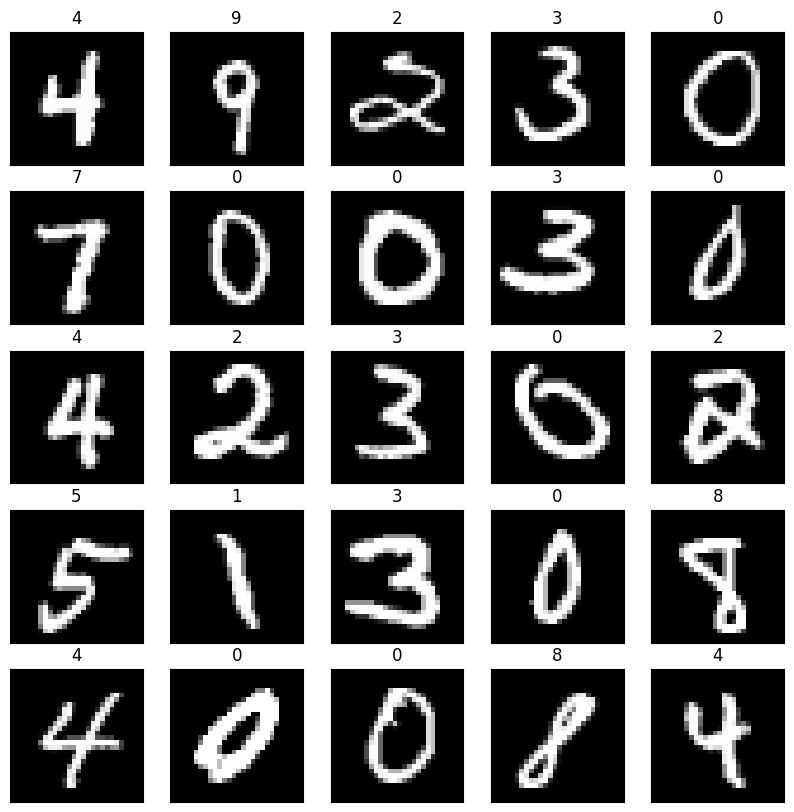

In [214]:
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(batch[0][i].numpy(), (1,2,0)), cmap='gray')
    ax.set_title(batch[1][i].item())

In [215]:
class MLPModel():
  def __init__(self, alpha, input_size, output_size, hidden_size):
    self.alpha=alpha
    self.W=np.random.randn(input_size, hidden_size) * np.sqrt(2.0/input_size)
    self.V=np.random.randn(hidden_size, output_size)* np.sqrt(2.0/hidden_size)
    self.w=np.zeros((1, hidden_size))
    self.v=np.zeros((1, output_size))


  def relu(self, input):
    return np.maximum(0, input)

  def reludiff(self, input):
    return input > 0

  def softmax(self, x):
    nums_shifted = x - np.max(x, axis=1, keepdims=True)
    nums = np.exp(nums_shifted)
    denom = np.sum(nums, axis=1, keepdims=True)
    return nums / denom

  def cross_entropy_loss(self, y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1. - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))


  def forward(self, x):
    self.s=np.dot(x, self.W)+self.w
    self.z=self.relu(self.s)
    t=np.dot(self.z, self.V)+self.v
    g=self.softmax(t)
    return g

  def backward(self, x, y_pred, y_true):
    y_true=np.array(y_true)
    self.dz2 = (y_pred - y_true) / batch_size

    self.dV = np.dot(self.z.T, self.dz2)
    self.dv = np.sum(self.dz2, axis=0, keepdims=True)

    self.dz1 = np.dot(self.dz2, self.V.T) * self.reludiff(self.s)
    self.dW = np.dot(x.T, self.dz1)
    self.dw = np.sum(self.dz1, axis=0, keepdims=True)

  def optimization_step(self):
    self.W -= self.alpha * self.dW
    self.w -= self.alpha * self.dw
    self.V -= self.alpha * self.dV
    self.v -= self.alpha * self.dv

  def fit(self, epochs):
    losses_train=[]
    losses_test=[]
    accuracy_test=[]
    batches_train = train_data.get_all_batches(100)
    batches_test = test_data.get_all_batches(100)
    for epoch in range(epochs):
      loss_epoch_train=0
      loss_epoch_test=0
      acc_test=0
      acc_train=0
      for train_batch in batches_train:
        x, y = np.array(train_batch[0]), train_batch[1]
        output = self.forward(x)
        loss = self.cross_entropy_loss(output, y)

        self.backward(x, output, y)

        self.optimization_step()

        loss_epoch_train+=loss
        true = np.argmax(np.array(y), axis=1)
        pred = np.argmax(output, axis=1)
        accuracy = np.sum(true == pred)
        acc_train+=accuracy

      for test_batch in batches_test:
        x, y = np.array(test_batch[0]), test_batch[1]
        output = self.forward(x)
        loss = self.cross_entropy_loss(output, y)
        loss_epoch_test+=loss

        true = np.argmax(np.array(y), axis=1)
        pred = np.argmax(output, axis=1)
        accuracy = np.sum(true == pred)
        acc_test+=accuracy

      print("epoch ", epoch)
      print("train loss:", loss_epoch_train * batch_size / train_data.len)
      print("train accuracy:", acc_train * 100/ train_data.len,"%")
      print("test loss:", loss_epoch_test * batch_size / test_data.len)
      print("test accuracy:", acc_test * 100/ test_data.len, "%")
      print("~~~~~~~~~~~~")
      losses_train.append(loss_epoch_train * batch_size / train_data.len)
      losses_test.append(loss_epoch_test * batch_size / train_data.len)
      accuracy_test.append(acc_test * 100/ test_data.len)

    return losses_train, losses_test, accuracy_test


In [216]:
model = MLPModel(0.1, 28*28, 10, 300)

In [217]:
metrics = model.fit(20)

epoch  0
train loss: 2.5046225031789686
train accuracy: 92.97833333333334 %
test loss: 1.48240347767223
test accuracy: 95.08 %
~~~~~~~~~~~~
epoch  1
train loss: 1.1409606556709364
train accuracy: 97.08833333333334 %
test loss: 1.1097098200476225
test accuracy: 95.81 %
~~~~~~~~~~~~
epoch  2
train loss: 0.8122590976053686
train accuracy: 98.03666666666666 %
test loss: 0.925608646382545
test accuracy: 96.26 %
~~~~~~~~~~~~
epoch  3
train loss: 0.6147536820392164
train accuracy: 98.59 %
test loss: 0.8213307882231802
test accuracy: 96.53 %
~~~~~~~~~~~~
epoch  4
train loss: 0.47745176513345994
train accuracy: 99.03833333333333 %
test loss: 0.753991115901374
test accuracy: 96.65 %
~~~~~~~~~~~~
epoch  5
train loss: 0.37619693159062734
train accuracy: 99.32166666666667 %
test loss: 0.6967475511386689
test accuracy: 96.84 %
~~~~~~~~~~~~
epoch  6
train loss: 0.29910426554168945
train accuracy: 99.53166666666667 %
test loss: 0.6581564799324755
test accuracy: 96.88 %
~~~~~~~~~~~~
epoch  7
train loss